# Classifying Heart Disease

We'll also be looking at the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UCI Machine Learning Repository. This dataset comes from the Cleveland Clinic Foundation, which recorded information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual using Logistic Regression.


## Data exploration

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

heart = pd.read_csv('heart_disease.csv')

# Exploring thr data
print(heart.info())
print(heart.head())

# Descriptive statistics
num_vars = heart.columns[heart.dtypes != 'object']
print(heart[num_vars].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    object 
 13  thal        303 non-null    object 
 14  present     303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB
None
   Unnamed: 0  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0           1   63    1   1       145   233    1    

After consulting the documentation and checking the descriptives statistics, we decide to drop or recode some variables. The column `Unnamed: 0`can be dropped, as it is just a running identification number that doesn't add more than the existing index. There are various variables that should be treated as dummy variables, while now some are coded as ordinal or interval scaled:
- `sex` (1 refers to males)
- `cp: chest pain type`; we create dummies for these four categories:
    - Value 1: typical angina (Reference)
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- `fbs: (fasting blood sugar > 120 mg/dl)` (1 = yes; 2= no)
- `restecg: resting electrocardiographic results`; we create dummies for these three categories:
    - Value 0: normal (Reference)
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- `exang: exercise induced angina` (1 = yes; 0 = no)
- ` slope: the slope of the peak exercise ST segment`; we create dummies for these three categories:
    - Value 1: upsloping 
    - Value 2: flat
    - Value 3: downsloping
- `ca: number of major vessels (0-3) colored by flourosopy` (Reference is 0)
- `thal:`; we create dummies for these three categories:
    - Value 3: normal
    - Value 6: fixed defect
    - Value 7: reversable defect

In [2]:
# Drop Unnamed column
heart = heart.drop(columns='Unnamed: 0')

# Replace missing values in thal a ca columsn as Nones
heart[heart['thal'] == "?"] = None
heart[heart['ca'] == "?"] = None

# Recode selected variables as dummies
heart_incl_dummies = pd.get_dummies(heart, columns=['cp', 'restecg', 'slope', 'ca', 'thal'], drop_first=True, dtype=float)

heart_incl_dummies

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,present,cp_2.0,...,cp_4.0,restecg_1.0,restecg_2.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
301,57.0,0.0,130.0,236.0,0.0,174.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Checking distributions and bivariate relationships

Before we move on, let us check how the numeric and categorical variables are distributed and how they relate to our outcome variable `present`. For the numeric variables, let us form quintiles and compare the share of present heart disease cases in each quintile of the continuous predictors.

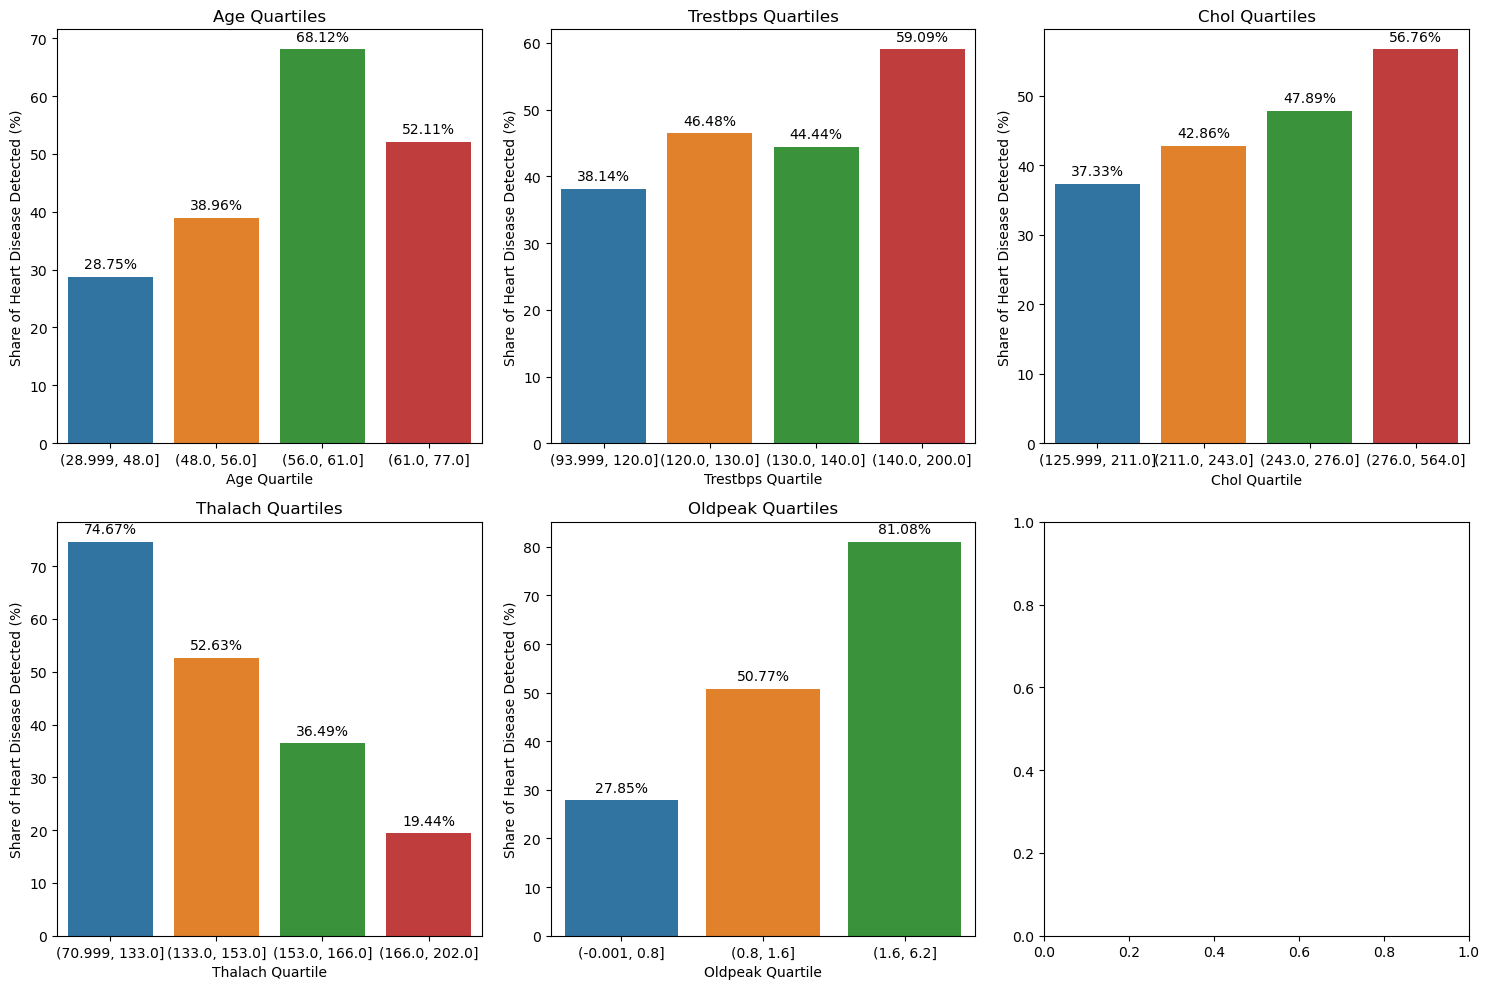

In [3]:
# Reset the numerical variable list
num_vars =['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Recode the continuous variables into quartiles
for var in num_vars:
    heart[f'{var}_quartile'] = pd.qcut(heart[var], q=4, duplicates='drop')

# Gridplot, each subplot is a barchart of share of Heart Disease in quartile
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, var in enumerate(num_vars):
    quartile_col = f'{var}_quartile'
    quartile_means = heart.groupby(quartile_col)['present'].mean().reset_index()
    quartile_means['present'] *= 100  # Convert to percentage

    sns.barplot(x=quartile_col, y='present', data=quartile_means, ax=axes[i])

    for p in axes[i].patches:
        percentage = f'{p.get_height():.2f}%'
        axes[i].annotate(percentage, 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', fontsize=10, color='black', 
                         xytext=(0, 9), textcoords='offset points')

    axes[i].set_title(f'{var.capitalize()} Quartiles')
    axes[i].set_xlabel(f'{var.capitalize()} Quartile')
    axes[i].set_ylabel('Share of Heart Disease Detected (%)')

plt.tight_layout()
plt.show()

What we can see here is that the risk of being diagnosed with a heart disease increases with age, resting blodd pressure (`trestbps`), cholesterol and the previous peak measurement (`oldpeak`). But we should note that the relationship with age seems to be curvelinear, so let us include a squared term for age in our model. The `thalach` variable shows a negative relationship with heart disease, but this is linear.

What do we observe for our cetegorical variables?

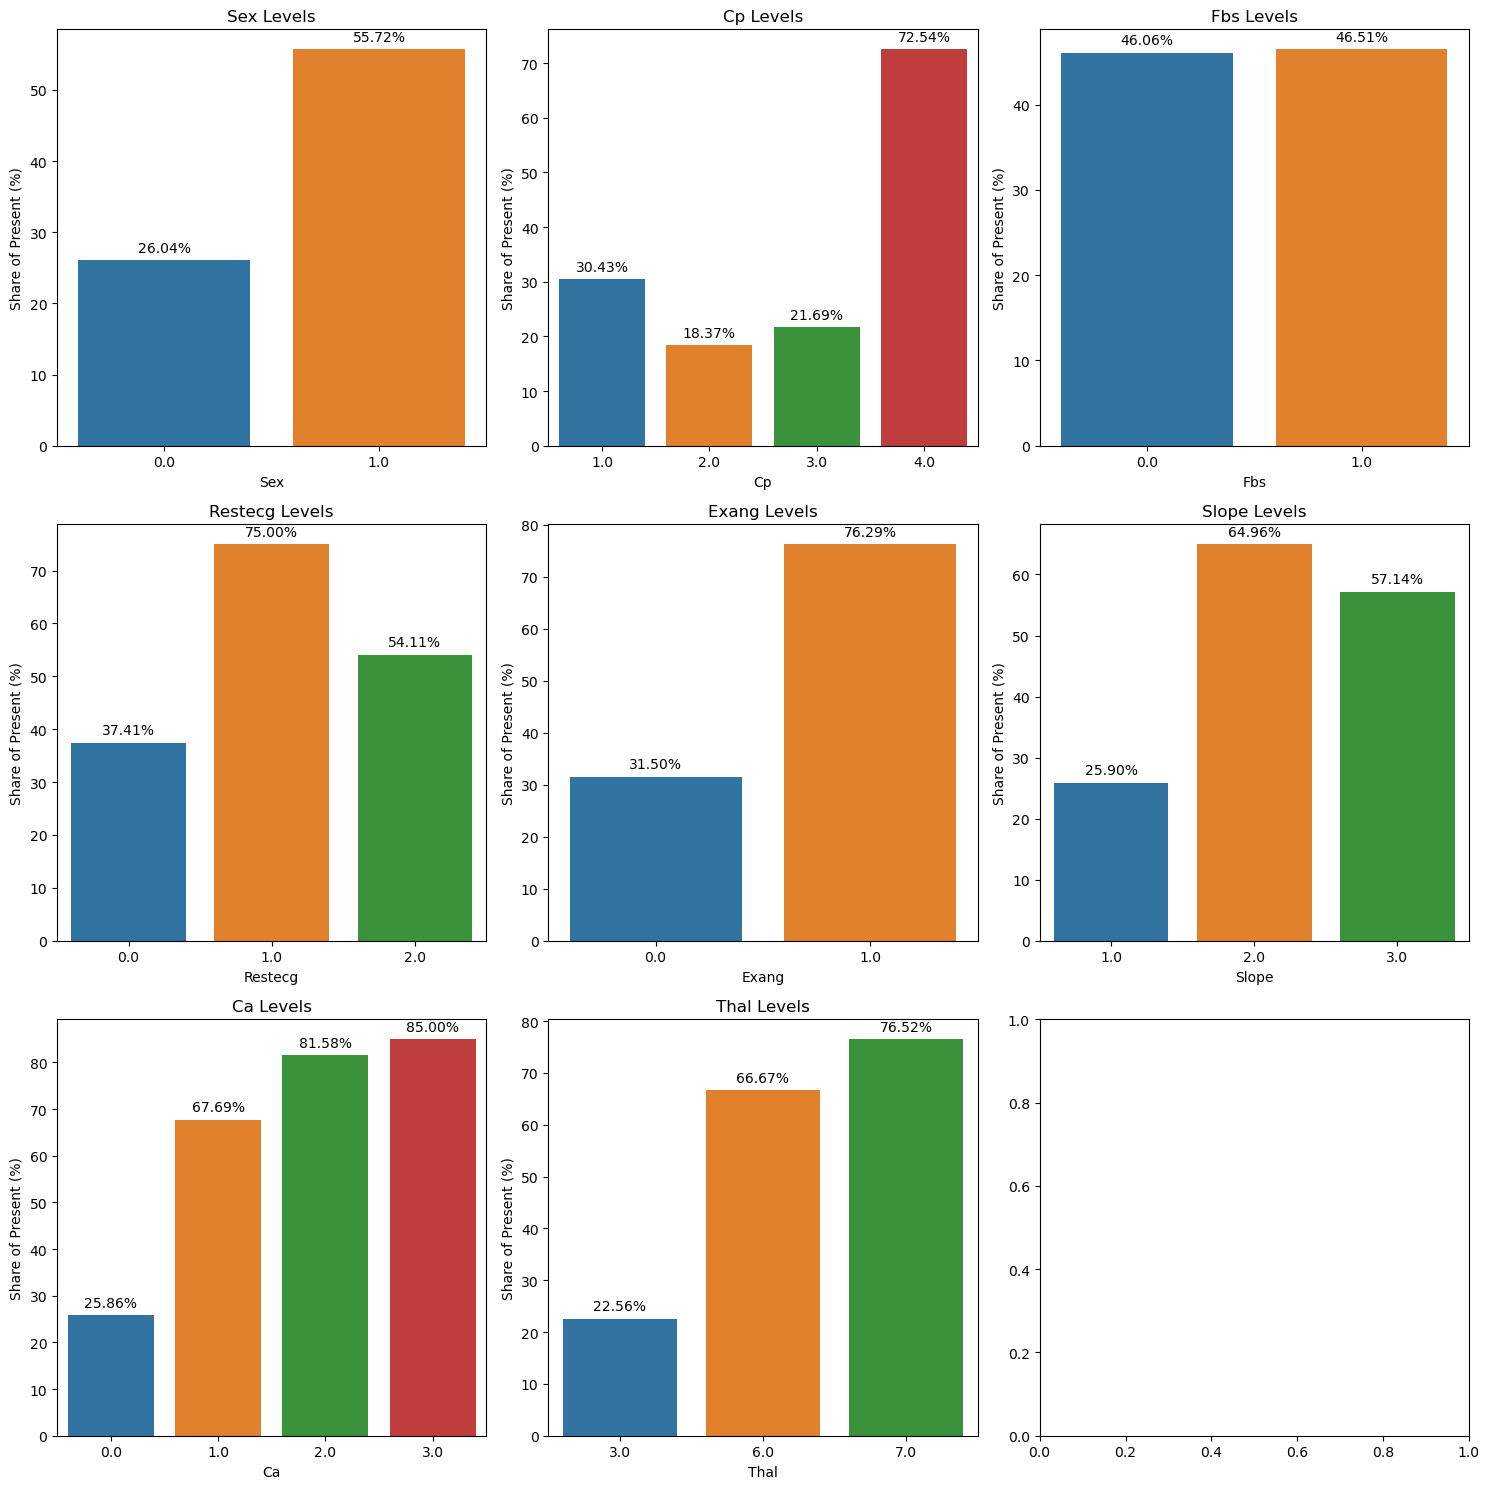

In [4]:
# List of categorical variables
cat_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Gridplot, each subplot is a barchart of share of Heart Disease in category
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust the grid size to fit the number of categorical variables
axes = axes.flatten()

for i, var in enumerate(cat_vars):
    cat_means = heart.groupby(var)['present'].mean().reset_index()
    cat_means['present'] *= 100 

    sns.barplot(x=var, y='present', data=cat_means, ax=axes[i])

    for p in axes[i].patches:
        percentage = f'{p.get_height():.2f}%'
        axes[i].annotate(percentage, 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', fontsize=10, color='black', 
                         xytext=(0, 9), textcoords='offset points')

    axes[i].set_title(f'{var.capitalize()} Levels')
    axes[i].set_xlabel(f'{var.capitalize()}')
    axes[i].set_ylabel('Share of Present (%)')

plt.tight_layout()
plt.show()

The categorical variables also seem to work well as potential predictors. The share of predicted heart disease is higher among men (56%) than women (26%). The ytpe of chestpain (`cp`) also plays an important role. Here, we observe that the risk of detecting a heart disease is highest in the asymptomatic chest pain group (group 4), about 73%. Fasting blood sugar levels (`fbs`), however, seem to make no difference, as the risk is the same in low and elevated `fbs`groups. We may want to leave this variable out of our model. The resting electrocardiographic results `restecg` do play a role for heart disease. Patients in group 1 (ST-T wave abnormality) have a much higher risk, and those in group 2 (left ventricular hypertrophy) still have an elevated risk in comparison to the reference group. Exercised induced angina (`exang`) strongly predicts heart disease, and we find a higher risk in groups 2 and 3 of the `slope` measurement. All patients that have at least one coloured vessel by flourosopy `ca` show higher risk as well as groups 6 and 7 in the `thal`measure.

Overall it is reasonable to include these variable groups as dummies, since many of the relationships are not linear, which will be captured much better by categorical dummies.

After this exploratory data analysis, let us add a squared age column to our DataFrame and drop the `fbs`variable. Since we already have all the other dummy variables, we can move on to create training and test datasets after that.

In [5]:
# Drop fbs
heart_incl_dummies = heart_incl_dummies.drop(columns='fbs')

# Add age-squared
heart_incl_dummies['age_sq'] = heart_incl_dummies['age'] ** 2

# Reorder columns (age_sq after age)
cols = list(heart_incl_dummies.columns)  
cols.insert(cols.index('age') + 1, cols.pop(cols.index('age_sq')))  
heart_incl_dummies = heart_incl_dummies[cols]

# Let's also drop rows with missing values
heart_incl_dummies = heart_incl_dummies.dropna()

heart_incl_dummies

,age,age_sq,sex,trestbps,chol,thalach,exang,oldpeak,present,cp_2.0,...,cp_4.0,restecg_1.0,restecg_2.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,3969.0,1.0,145.0,233.0,150.0,0.0,2.3,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,67.0,4489.0,1.0,160.0,286.0,108.0,1.0,1.5,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67.0,4489.0,1.0,120.0,229.0,129.0,1.0,2.6,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,37.0,1369.0,1.0,130.0,250.0,187.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,41.0,1681.0,0.0,130.0,204.0,172.0,0.0,1.4,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,3249.0,0.0,140.0,241.0,123.0,1.0,0.2,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
298,45.0,2025.0,1.0,110.0,264.0,132.0,0.0,1.2,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
299,68.0,4624.0,1.0,144.0,193.0,141.0,0.0,3.4,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
300,57.0,3249.0,1.0,130.0,131.0,115.0,1.0,1.2,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## Dividing the data

We are now ready to divide our data into training and test sets, but we have to make sure that both sets contain cases and non-cases. We will assign 70% as our training set and 30% as test set. BWe will also scale the data in order to have a comparable range for each variable.

In [6]:
# Divide into training and test sets
X = heart_incl_dummies.drop(columns='present')
y = heart_incl_dummies['present']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)

In [7]:
print("Share of Heart Disease in training set:")
print(np.mean(y_train))
print('\n')
print("Share of Heart Disease in test set:")
print(np.mean(y_test))

Share of Heart Disease in training set:
0.45893719806763283


Share of Heart Disease in test set:
0.4666666666666667


It looks as if the distribution of cases with heart disease present and non-present are well represented in the train gas well as in the test data.

In [8]:
# Scaling the data

def scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled

X_train = scaler(X_train)
X_test = scaler(X_test)

## Building the model

Let's build the classification model and perform some initial assessments on the training data. We will calculate accuracy, sensitivity and specificity. Additionally we will look at the positive predictive value as well as the negative predictive value to check how well our model predicts positive and negative cases.

In [9]:
# Building the model
model = LogisticRegression()
fit = model.fit(X_train, y_train)

In [10]:
# Calculating the accuracy score (training set)
accuracy_train = model.score(X_train, y_train)

# Calculating the sensitivity score (training set)
y_train_hat = model.predict(X_train)
tp_train = np.sum(y_train[y_train_hat == 1])
fn_train = np.sum(y_train[y_train_hat == 0])
sensitivity_train = tp_train / (tp_train + fn_train)

# Calculating specificity score (training set)
tn_train = np.sum(y_train[y_train_hat == 0] == 0)
fp_train = np.sum(y_train[y_train_hat == 1] == 0)
specificity_train = tn_train / (tn_train + fp_train)

# Calculating the PPV score (training set)
ppv_train = tp_train / (tp_train + fp_train)

# Calculating the PPV score (training set)
npv_train = tn_train / (tn_train + fn_train)

print("Model evaluation on training set:")
print("Accuracy score: ", accuracy_train)
print("Sensitivity score: ", sensitivity_train)
print("Specificity score: ", specificity_train)
print("Positive Predictive Value: ", ppv_train)
print("Negative Predictive Value: ", npv_train)

Model evaluation on training set:
Accuracy score:  0.8743961352657005
Sensitivity score:  0.8421052631578947
Specificity score:  0.9017857142857143
Positive Predictive Value:  0.8791208791208791
Negative Predictive Value:  0.8706896551724138


These initial assessments on our training data look encouraging.
We are able to correctly classify 87% of our cases (Accuracy); 84% of the true heart disease cases are detected (sensitivity) and 90% of the true negative cases (no heart disease) are also correctly classified. The Positive Predictive Value (PPV) indicates that we are getting 88% of the posive cases right that we predicted to be positive, i.e. showing a heart disease. Also based on the Negative Predictive Value (NPV), we are correctly classifying 87% of the negative cases (i.e. no disease), which we predicted to be negative.

## Interpreting the model coefficients

With these encouraging results, let's doublecheck if the coefficients in our model make sense and point into the direction that they should.

In [11]:
# Getting and transforming the coefficients
intercept = model.intercept_
coefficients = model.coef_
exp_intercept = np.exp(model.intercept_)
exp_coefficients = np.exp(model.coef_)

# Creating a regression summary table
index = ['Intercept'] + X.columns.tolist()
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=index)

exp_regression_table = pd.DataFrame({
    "Coefficient": np.append(exp_intercept, exp_coefficients),
}, index=index)

print("Regression Table (Log-odds ratios)")
print(regression_table)
print('\n')
print("Regression Table (Odds ratios)")
print(exp_regression_table)

Regression Table (Log-odds ratios)
             Coefficient
Intercept      -0.167406
age             0.087310
age_sq         -0.172197
sex             0.893700
trestbps        0.589302
chol            0.242581
thalach        -0.576956
exang           0.262052
oldpeak         0.185742
cp_2.0          0.179443
cp_3.0         -0.085591
cp_4.0          0.785263
restecg_1.0     0.232335
restecg_2.0     0.133781
slope_2.0       0.367925
slope_3.0       0.028024
ca_1.0          0.797700
ca_2.0          0.854752
ca_3.0          0.632307
thal_6.0       -0.034397
thal_7.0        0.617070


Regression Table (Odds ratios)
             Coefficient
Intercept       0.845856
age             1.091235
age_sq          0.841813
sex             2.444157
trestbps        1.802730
chol            1.274535
thalach         0.561605
exang           1.299595
oldpeak         1.204112
cp_2.0          1.196550
cp_3.0          0.917969
cp_4.0          2.192985
restecg_1.0     1.261542
restecg_2.0     1.143142
slope_2

Looking at these results, we find that they match the results which we obtained previously in our bivariate data analysis.
The age effect is curvelinear, initially positive then decreasing in higher age groups. Men are more likely to have a heart disease in comparison to women, their risk is increased by the factor 2.44, as the odds ratio shows. As before, we find positive effects of resting blood pressure levels (`trestbps`) and cholesterol (`chol`), with each unit increase being associated with an increased risk by the factor 1.80 and 1.27 respectively. The `thalach`measure has a strong negative effect (odds ratio = 0.56). The exercise induced angina variable and the `oldpeak`variable both show elevated risk for heart disease.

Among the categorical variables we observe that the asymptomatic group (`cp`= 4) has their risk of heart disease more than doubled compared to the typical angina group. Patients with any abnormalities found in the The resting electrocardiographic measure (`restercg`) both show elevated risk in comarison to the group without abnormal scores. As before, we find a higher risk in groups 2 and 3 of the `slope` measurement. All patients that have at least one coloured vessel by flourosopy `ca` show higher risk as well as groups 6 and 7 in the `thal`measure.

## Final model evaluation

Finally, we can assess the predictive ability of our logistic regression model. We therefore assess its performance on the test set.

In [12]:
# Calculating the accuracy score (test set)
accuracy_test = model.score(X_test, y_test)

# Calculating the sensitivity score (test set)
y_test_hat = model.predict(X_test)
tp_test = np.sum(y_test[y_test_hat == 1])
fn_test = np.sum(y_test[y_test_hat == 0])
sensitivity_test = tp_test / (tp_test + fn_test)

# Calculating specificity score (test set)
tn_test = np.sum(y_test[y_test_hat == 0] == 0)
fp_test = np.sum(y_test[y_test_hat == 1] == 0)
specificity_test = tn_test / (tn_test + fp_test)

# Calculating the PPV score (test set)
ppv_test = tp_test / (tp_test + fp_test)

# Calculating the PPV score (test set)
npv_test = tn_test / (tn_test + fn_test)

print("Model evaluation on test set:")
print("Accuracy score: ", accuracy_test)
print("Sensitivity score: ", sensitivity_test)
print("Specificity score: ", specificity_test)
print("Positive Predictive Value: ", ppv_test)
print("Negative Predictive Value: ", npv_test)

Model evaluation on test set:
Accuracy score:  0.8555555555555555
Sensitivity score:  0.8095238095238095
Specificity score:  0.8958333333333334
Positive Predictive Value:  0.8717948717948718
Negative Predictive Value:  0.8431372549019608


Also the final model evaluation looks good. In comparison to the results obtained on our training data, the results on the test data are very similar.

We are able to correctly classify 86% of our cases (Accuracy) (training: 87%); 81% of the true heart disease cases are detected (sensitivity) (training: 84%) and 90% of the true negative cases (no heart disease) are also correctly classified (training: 90%). The Positive Predictive Value (PPV) indicates that we are getting 87% of the posive cases right that we predicted to be positive (training: 88%), i.e. showing a heart disease. Also based on the Negative Predictive Value (NPV), we are correctly classifying 84% of the negative cases (i.e. no disease), which we predicted to be negative (training: 87%).

The differences are very small, and this indicates that we did not overfit our model.

## Conclusions

The model, which we mainly based on our initial exploration of bivariate relationships, delivers robust and sensible results. While the overall accuracy of 86% is fine, in a medical context we should still work on improving the Sensitivity of the model, if we plan to use it as an early screening tool. We do classify 81% of the cases with an actual heart disease correctly. But we also miss 19% of those cases which need treatment. This number would need to be reduced in improved versions of the model. One shouls also keep in mind that we dropped cases with missing values. In order to create sactisfactory results, we should find a sensible way to impute those cases. 